## Кейс №2 - Приложение доставки

### Общее описание:

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.
Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.
Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

### Описание данных

В данных вы найдете логи заказов пользователей:

*ab_users_data* – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
* `user_id` - идентификатор пользователя
* `order_id` - идентификатор заказа
* `action` - действие, которое совершил пользователь (создал или отменил заказ)
* `time` - время совершенного действия 
* `date` - дата совершенного действия
* `group` - группа пользователей (1 - пользователи с новой системой, 0 - пользователи со старой системой)

*ab_orders* – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
* `order_id` - идентификатор заказа
* `creation_time` - время создания заказа
* `product_ids` - список идентификаторов продуктов

*ab_products* – подробная информация о продуктах, их название и стоимость
* `product_id` - идентификатор продукта 
* `name` - название продукта 
* `price` - цена продукта

### Обзор и предобработка данных

In [75]:
# импорт библиотек

import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import chi2_contingency, chi2
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from scipy import stats as st
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
# чтение файлов с данными и сохранение в df

try:
    users, orders, products = (
        pd.read_csv('ab_users_data.csv'),
        pd.read_csv('ab_orders.csv'),
        pd.read_csv('ab_products.csv')
    )


except:
    users, orders, products = (
        pd.read_csv('ab_users_data.csv'),
        pd.read_csv('ab_orders.csv'),
        pd.read_csv('ab_products.csv')
    )

Напишем функцию, которая поможет нам с обзором всех датафреймов.

In [3]:
def data_info(data):
    
# функция выводит информацию о датафрейме
# входной параметр: датафрейм

    display(data.head())
    print(data.info())
    display(data.describe())
    print('Явных дубликатов:', data.duplicated().sum())
    print('Доля явных дубликатов:', data.duplicated().sum() / len(data))
    print('Пропущенные значения:\n', data.isna().sum())

#### `users`

In [4]:
data_info(users)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB
None


,user_id,order_id,group
count,4337.000000,4337.000000,4337.000000
mean,1466.771270,16362.859811,0.610099
std,290.451607,16609.671919,0.487784
min,964.000000,1255.000000,0.000000
25%,1220.000000,2444.000000,0.000000
50%,1463.000000,9615.000000,1.000000
75%,1710.000000,26920.000000,1.000000
max,1980.000000,59533.000000,1.000000


Явных дубликатов: 0
Доля явных дубликатов: 0.0
Пропущенные значения:
 user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64


In [5]:
users['action'].unique()

array(['create_order', 'cancel_order'], dtype=object)

Данные `users` о 4337 пользователях. Дубликатов и пропусков в данных нет. Отметим, что у столбцов `time` и `date` необходимо заменить тип данных.

In [6]:
# меняем тип поля на datetime

users['time'] = pd.to_datetime(users['time'], format = '%Y-%m-%d %H:%M:%S.%f')

In [7]:
# меняем тип поля на datetime

users['date'] = pd.to_datetime(users['date'], format = '%Y-%m-%d')

#### `orders`

In [8]:
data_info(orders)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB
None


,order_id
count,4123.000000
mean,16387.899103
std,16644.518947
min,1255.000000
25%,2444.500000
50%,9614.000000
75%,27000.000000
max,59533.000000


Явных дубликатов: 0
Доля явных дубликатов: 0.0
Пропущенные значения:
 order_id         0
creation_time    0
product_ids      0
dtype: int64


Всего 4123 заказа. Дубликатов и пропусков нет. Отметим, что у столбца `creation_time` необходимо заменить тип данных.

In [9]:
# меняем тип поля на datetime

orders['creation_time'] = pd.to_datetime(orders['creation_time'], format = '%Y-%m-%d %H:%M:%S.%f')

#### `products`

In [10]:
data_info(products)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB
None


,product_id,price
count,87.000000,87.000000
mean,44.000000,133.581609
std,25.258662,136.127922
min,1.000000,1.000000
25%,22.500000,55.000000
50%,44.000000,76.300000
75%,65.500000,160.000000
max,87.000000,800.000000


Явных дубликатов: 0
Доля явных дубликатов: 0.0
Пропущенные значения:
 product_id    0
name          0
price         0
dtype: int64


Всего 87 продуктов. Дубликатов и пропусков нет.

### Анализ результатов А/Б-теста

Посмотрим на время проведения теста.

In [11]:
print('Данные о заказах с %s по %s' % (orders['creation_time'].min(), orders['creation_time'].max()))
print('Набор пользователей с %s по % s'% (users['date'].min(), users['date'].max()))

Данные о заказах с 2022-08-26 00:00:19 по 2022-09-08 23:41:24
Набор пользователей с 2022-08-26 00:00:00 по 2022-09-08 00:00:00


Мы знаем, что у нас есть 2 группы для А/Б-теста. В группе 1 оказались пользователи с новой системой рекомендаций товаров, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Посмотрим на количество участников в каждой группе.

Мы видим, что у нас есть пользователи, которые отменили заказ. Для дальнейшего анализа их необходимо удалить.

In [12]:
users.groupby(['action', 'group']).agg({'user_id': 'nunique'})

user_id
action       group         
cancel_order 0           76
             1          113
create_order 0          515
             1          502

In [13]:
# отмененные заказы

cancel_orders = users.loc[users.action == 'cancel_order'].order_id.tolist()

In [14]:
# без учета отмененных заказов

users_orders_created = users[~users['order_id'].isin(cancel_orders)]

In [15]:
users_orders_created.groupby('group').agg(count=('user_id', 'nunique'))

,count
group,
0,512
1,501


В тесте участвует 1013 уникальных пользователей для созданных заказов, количество участников распределено по группам равномерно; проверим, что участники не попадают одновременно в группу 1 и 2.

In [16]:
users_orders_created.groupby('user_id').agg({'group':'nunique'}).reset_index().query('group > 1')

,user_id,group


Таких участников нет.

Для того, чтобы ответить на вопрос, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения, рассмотрим и сравним для каждой группы следующие метрики:
* количество заказов
* выручка по дням
* средний чек по дням

#### Количество заказов

Для начала посмотрим на количество заказов по пользователям для каждой группы.

In [17]:
# количество заказов по пользвателям группы со старой системой

orders_by_users_0 = users_orders_created.query("group == 0").groupby('user_id', as_index=False).agg({'order_id': 'nunique'})
orders_by_users_0

,user_id,order_id
0,964,2
1,968,3
2,969,2
3,972,1
4,975,2
...,...,...
507,1971,3
508,1972,2
509,1973,4
510,1974,3


In [18]:
# количество заказов по пользвателям группы с новой системой

orders_by_users_1 = users_orders_created.query("group == 1").groupby('user_id', as_index=False).agg({'order_id': 'nunique'})
orders_by_users_1

,user_id,order_id
0,965,9
1,967,5
2,970,2
3,971,5
4,973,3
...,...,...
496,1976,5
497,1977,4
498,1978,6
499,1979,5


count    512.000000
mean       2.982422
std        1.886631
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: orders, dtype: float64

count    501.000000
mean       4.754491
std        2.138599
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: orders, dtype: float64

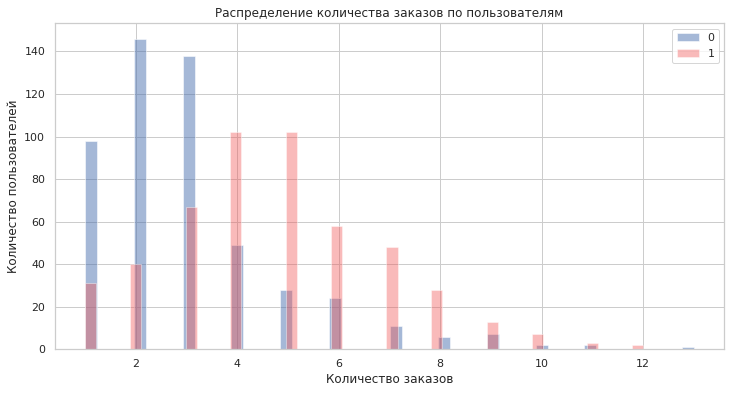

In [19]:
orders_by_users_0.columns =  ['user_id', 'orders']
orders_by_users_1.columns =  ['user_id', 'orders']

display(orders_by_users_0['orders'].describe())
display(orders_by_users_1['orders'].describe())

# строим гистограмму
plt.hist(orders_by_users_0['orders'], bins = 50,  label = '0', alpha=0.5)
plt.hist(orders_by_users_1['orders'], bins = 50,  color = '#f05454', label = '1', alpha=0.4)
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

На графике видим, что количество заказов на пользователя новой системы растет относительно количества заказов на пользователя старой системы. Проверим статистическую значимость различий количества заказов по пользователям между группами. 

Сформулируем нулевую гипотезу: 
H<sub>0</sub>: Количество заказов на пользователя новой и старой системы одинаковы.

Альтернативную гипотезу: 
H<sub>1</sub>: Количество заказов на пользователя новой и старой системы отличаются.

Зафиксируем уровень значимости **alpha = 0.05**

Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод st.stats.ttest_ind.
Если p-value будет меньше выбранного уровня значимости, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [20]:
alpha = .05   # критический уровень статистической значимости    
results = st.stats.ttest_ind(orders_by_users_0.orders, 
                             orders_by_users_1.orders)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  8.430777321728061e-41
Отвергаем нулевую гипотезу


Мы отвергаем гипотезу: различие в количестве заказов на пользователя для групп со старой и новой системой рекомендации товаров имеет статистически значимую разницу.

In [80]:
print('Cреднее количество заказов на пользователя в группе со старой системой рекомендации товаров - %s' 
                                          % (round(orders_by_users_0.orders.mean(), 2)))
print('Cреднее количество заказов на пользователя в группе с новой системой рекомендации товаров - %s' 
                                          % (round(orders_by_users_1.orders.mean(), 2)))
print('Среднее количество заказов на пользователя новой версии изменилось по сравнению со старой на {0:.3%}'
                                          .format(orders_by_users_1.orders.mean() / orders_by_users_0.orders.mean()-1))

Cреднее количество заказов на пользователя в группе со старой системой рекомендации товаров - 2.98
Cреднее количество заказов на пользователя в группе с новой системой рекомендации товаров - 4.75
Среднее количество заказов на пользователя новой версии изменилось по сравнению со старой на 59.417%


#### Выручка и средний чек по группам

Мы теперь знаем, что в результате использования новой системы рекомендации товара для приложения количество заказов увеличивается. Но для того чтобы понять, смогла ли она принести пользу бизнесу, сравним выручку по дням для старой и новой системы. Для этого нужно собрать соответствующий датафрейм с указанной ценой.

In [22]:
# преобразуем данные по заказам в столбце с товарами

orders['product_ids'] = orders['product_ids'].apply(lambda x: x.replace('{', '').replace('}', '').split(', '))

In [23]:
orders = orders.explode('product_ids').rename(columns={'product_ids': 'product_id'})

In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13826 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       13826 non-null  int64         
 1   creation_time  13826 non-null  datetime64[ns]
 2   product_id     13826 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 432.1+ KB


In [25]:
# меняем тип данных

orders['product_id'] = orders['product_id'].astype('int')

In [26]:
# объединяем данные по заказам с данными по продуктам и их ценой

orders_price = orders.merge(products[['product_id', 'price']], on='product_id', how='left')

In [27]:
# посчитаем стоимость по заказам

price_by_orders = orders_price.groupby(['order_id', 'creation_time'], as_index=False).agg({'price': 'sum'})

In [28]:
price_by_orders.head()

,order_id,creation_time,price
0,1255,2022-08-26 00:00:19,408.7
1,1256,2022-08-26 00:02:21,250.5
2,1257,2022-08-26 00:02:27,310.2
3,1258,2022-08-26 00:02:56,85.0
4,1259,2022-08-26 00:03:37,228.0


In [29]:
# объединим полученные данные с данными по пользователям

orders_total_price = price_by_orders.merge(users_orders_created[['order_id', 'group']], on='order_id')

In [30]:
orders_total_price.head()

,order_id,creation_time,price,group
0,1255,2022-08-26 00:00:19,408.7,0
1,1256,2022-08-26 00:02:21,250.5,1
2,1257,2022-08-26 00:02:27,310.2,0
3,1259,2022-08-26 00:03:37,228.0,1
4,1261,2022-08-26 00:05:35,430.7,0


In [31]:
orders_total_price.set_index(keys='creation_time', drop=True, inplace=True)

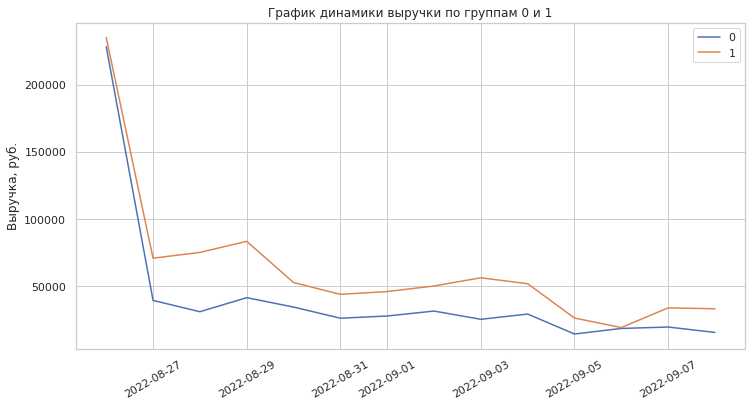

In [32]:
# датафрейм с выручкой по дням в группе 0
revenue_0 = orders_total_price.query('group == "0"').resample(rule='D').agg({'price': 'sum'}).reset_index()

# датафрейм с выручкой по дням в группе 1
revenue_1 = orders_total_price.query('group == "1"').resample(rule='D').agg({'price': 'sum'}).reset_index()

plt.plot(revenue_0['creation_time'], revenue_0['price'], label='0')
plt.plot(revenue_1['creation_time'], revenue_1['price'], label='1')
plt.title('График динамики выручки по группам 0 и 1')
plt.ylabel("Выручка, руб.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Мы видим, что выручка группы со старой версией приложения меньше, чем у группы с новой версией.
При этом в целом в обеих группах выручка снижается.

Посмотрим на средний чек по группам.

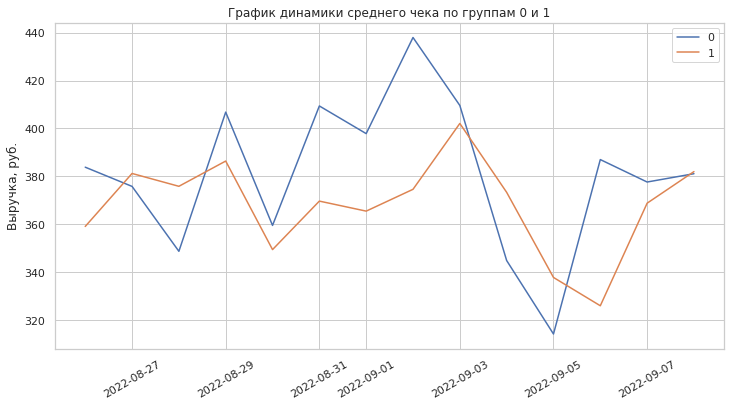

In [34]:
# датафрейм со средним чеком по дням в группе 0
avg_check_0 = orders_total_price.query('group == "0"').resample(rule='D').agg({'price': 'mean'}).reset_index()

# датафрейм со средним чеком по дням в группе 1
avg_check_1 = orders_total_price.query('group == "1"').resample(rule='D').agg({'price': 'mean'}).reset_index()

plt.plot(avg_check_0['creation_time'], avg_check_0['price'], label='0')
plt.plot(avg_check_1['creation_time'], avg_check_1['price'], label='1')
plt.title('График динамики среднего чека по группам 0 и 1')
plt.ylabel("Выручка, руб.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Если в случае выручки мы наблюдали ровную динамику по обеим группам, то здесь мы видим, что средний чек менялся и в большую, и в меньшую сторону относительно каждой группы.

Посчитаем статистическую значимость различий в среднем чеке между группами.

Посмотрим на распределение данных по группам, определим, распределены ли данные нормально.

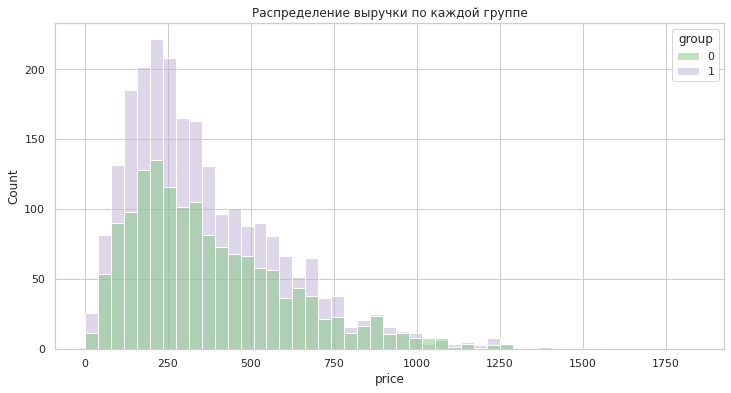

In [47]:
sns.histplot(data = orders_total_price, x="price", hue = "group", palette = "Accent")
plt.title('Распределение выручки по каждой группе')
plt.show()

Тестируем нормальность:

In [66]:
price_group_0 = orders_total_price.query("group == '0'").price
price_group_1 = orders_total_price.query("group == '1'").price

In [67]:
#через scipy 

print(ss.shapiro(price_group_0))
print(ss.shapiro(price_group_1))

ShapiroResult(statistic=0.9170262217521667, pvalue=3.811183766866527e-28)
ShapiroResult(statistic=0.9005318880081177, pvalue=8.388620126125922e-37)


In [54]:
#через pingouin

pg.normality(data=orders_total_price, dv="price", group="group", method="normaltest")

,W,pval,normal
0,276.039777,1.144785e-60,False
1,586.947838,3.514766e-128,False


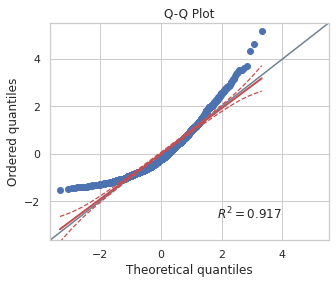

In [68]:
#qq-plots

pg.qqplot(price_group_0)

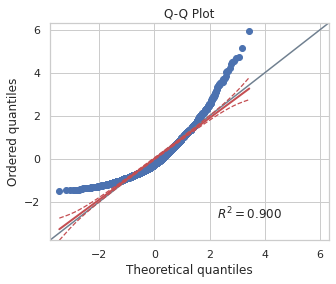

In [69]:
pg.qqplot(price_group_1)

Мы видим, что распределения не являются нормальными. 

Сформулируем нулевую гипотезу: 
H<sub>0</sub>: Различий в среднем чеке между группами нет.

Альтернативную гипотезу: 
H<sub>1</sub>: Различия в среднем чеке между группами есть.

Зафиксируем уровень значимости **alpha = 0.05**

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. А ещё найдём относительные различия в среднем чеке между группами.

In [78]:
#манна-уитни

alpha = 0.05
p_value = stats.mannwhitneyu(price_group_0, price_group_1)[1]
print("P-value: {0:.3f}".format(p_value))
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
print("Относительный прирост 1 к 0: {0:.3%}".format(price_group_1.mean() / price_group_0.mean()-1))

P-value: 0.075
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост 1 к 0: -3.463%


P-value не значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Хотя разница между средними чеками групп все же есть.

### Выводы

* Есть статистически значимое различие по количеству заказов на пользователя между группами, причем среднее количество заказов на пользователя новой версии изменилось по сравнению со старой на 59.417%
* Нет статистически значимого различия по среднему чеку между группами, при этом средний чек группы пользователей новой версии выше группы пользователей старой версии на 3.463%
* График динамики выручки по группам показывает, что выручка группы со старой версией приложения меньше, чем у группы с новой версией

На основании вышеизложенного можем считать, что новая система рекомендаций принесет пользу бизнесу и пользователям приложения, и ее можно включить на всех пользователей.